### ReAct Agent Architecture 


Aim 

This is the intuition behind ReAct, a general agent architecture.

1. <b>act</b> - let the model call specific tools 
2. <b>observe</b> - pass the tool output back to the model.
3. <b>reason</b> - let the model reason about the tool output to decide what to do next(eg. call another tool or just respond directly.)

In [13]:
from langchain_community.tools import WikipediaQueryRun,ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper
from rich import print
api_wrapper_wiki=WikipediaAPIWrapper(top_k_results=2)
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

In [2]:
print(wiki.name,arxiv.name)

wikipedia arxiv


In [17]:
import os
from dotenv import load_dotenv
load_dotenv(dotenv_path="../.env")   

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACKING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="React-agent"

In [9]:
# custom functions for agent to use 

def multiply(a:int,b:int)->int:
    """Multiply a and b.
    Args:
        a (int): first number
        b (int): second number 
    """
    return a * b

# this will be a tool 

def add(a:int,b:int)->int:
    """ Adds a and b

    Args:
    a:first int
    b: second int  
    """

    return a+b

def divide(a:int,b:int)->int:
    """ 
    Divide a and b

    Args: 
    a: first int
    b: second int
    """
    return a/b 


tools=[arxiv,wiki,add,multiply,divide]

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily=TavilySearchResults()

/var/folders/dd/ffn14k7x4bz7kmmd0l7kmqg80000gn/T/ipykernel_58635/3880125110.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily=TavilySearchResults()


In [11]:
tools.append(tavily)

In [14]:
print(tools)

[
    ArxivQueryRun(
        api_wrapper=ArxivAPIWrapper(
            arxiv_search=<class 'arxiv.Search'>,
            arxiv_exceptions=(
                <class 'arxiv.ArxivError'>,
                <class 'arxiv.UnexpectedEmptyPageError'>,
                <class 'arxiv.HTTPError'>
            ),
            top_k_results=2,
            ARXIV_MAX_QUERY_LENGTH=300,
            continue_on_failure=False,
            load_max_docs=100,
            load_all_available_meta=False,
            doc_content_chars_max=4000
        )
    ),
    WikipediaQueryRun(
        api_wrapper=WikipediaAPIWrapper(
            wiki_client=<module 'wikipedia' from 
'/Users/abhi/Desktop/Agentic_ai/LangGraph/venv/lib/python3.12/site-packages/wikipedia/__init__.py'>,
            top_k_results=2,
            lang='en',
            load_all_available_meta=False,
            doc_content_chars_max=4000
        )
    ),
    <function add at 0x11c20b4c0>,
    <function multiply at 0x11c20a8e0>,
    <function divide at 0x11c20ad40>,
    TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))
]

In [19]:
from langchain_groq import ChatGroq

llm=ChatGroq(model="openai/gpt-oss-120b")

llm_with_tools=llm.bind_functions(tools)

/var/folders/dd/ffn14k7x4bz7kmmd0l7kmqg80000gn/T/ipykernel_58635/3616102039.py:5: LangChainDeprecationWarning: The method `ChatGroq.bind_functions` was deprecated in langchain-groq 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_groq.chat_models.ChatGroq.bind_tools` instead.
  llm_with_tools=llm.bind_functions(tools)


In [21]:
from pprint import pprint
from langchain_core.messages import AIMessage,HumanMessage

print(llm_with_tools.invoke([HumanMessage(content=f"What is the recent ai news")]))

AIMessage(
    content='',
    additional_kwargs={
        'reasoning_content': 'The user asks: "What is the recent ai news". Likely they want a summary of recent AI 
news. Need up-to-date info. Use web search. Use tavily_search_results_json for recent AI news.',
        'tool_calls': [
            {
                'id': 'fc_000d65a0-5347-45c0-b66f-8237fcf66ffa',
                'function': {
                    'arguments': '{"query":"latest AI news September 2025"}',
                    'name': 'tavily_search_results_json'
                },
                'type': 'function'
            }
        ]
    },
    response_metadata={
        'token_usage': {
            'completion_tokens': 82,
            'prompt_tokens': 391,
            'total_tokens': 473,
            'completion_time': 0.162712006,
            'prompt_time': 0.017674902,
            'queue_time': 0.053506798,
            'total_time': 0.180386908
        },
        'model_name': 'openai/gpt-oss-120b',
        'system_fingerprint': 'fp_3a688838c3',
        'service_tier': 'on_demand',
        'finish_reason': 'tool_calls',
        'logprobs': None
    },
    id='run--aeaa64e1-e1bc-4bbc-9086-aba7337f2ae9-0',
    tool_calls=[
        {
            'name': 'tavily_search_results_json',
            'args': {'query': 'latest AI news September 2025'},
            'id': 'fc_000d65a0-5347-45c0-b66f-8237fcf66ffa',
            'type': 'tool_call'
        }
    ],
    usage_metadata={'input_tokens': 391, 'output_tokens': 82, 'total_tokens': 473}
)

In [ ]:
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# state schema 
class state(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [26]:
from IPython.display import display,Image
from langgraph.graph import START,END,StateGraph
from langgraph.prebuilt import ToolNode,tools_condition


In [24]:
def llm_tools(state:state):
    return {"messages":llm_with_tools.invoke(state["messages"])}

In [27]:
# lets build graph 

# lets add nodes 
builder=StateGraph(state)
builder.add_node("llm_tools",llm_tools)
builder.add_node("tools",ToolNode(tools))

# lets add edges 

builder.add_edge(START,"llm_tools")
builder.add_conditional_edges("llm_tools",tools_condition)
builder.add_edge('tools',"llm_tools")
builder.add_edge("llm_tools",END)


In [28]:
graph=builder.compile()

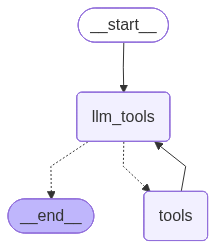

In [29]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
from pprint import pprint
messages=graph.invoke({"messages":HumanMessage(content="provide me the top 5 recent ai news , add 5 plus 5 and then multiply by 10.")})

for i in messages['messages']:
    i.pretty_print()

================================ Human Message =================================

provide me the top 5 recent ai news , add 5 plus 5 and then multiply by 10.
================================== Ai Message ==================================
Tool Calls:
  add (fc_c5e941d7-60ae-4369-a393-578d67c03ef8)
 Call ID: fc_c5e941d7-60ae-4369-a393-578d67c03ef8
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: add

10
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_55946858-8d6e-4f80-9d5d-56c39e9c9928)
 Call ID: fc_55946858-8d6e-4f80-9d5d-56c39e9c9928
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: multiply

100
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (fc_241d9f97-5c66-4712-bdb8-ee54e883cc76)
 Call ID: fc_241d9f97-5c66-4712-bdb8-ee54